## Introduction
This notebook uses trainplotkit with fastai.

The model and data are based on the [Computer vision intro](https://docs.fast.ai/tutorial.vision.html) tutorial on the [fastai documentation site](https://docs.fast.ai/).

This notebook also acts as preparation for the implementation of adapters to minimize the code needed to use trainplotkit with fastai.


## Imports

In [1]:
import sys, importlib
import fastai.vision.all as fv
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torcheval.metrics import MulticlassAccuracy
import numpy as np

sys.path.append('..')
from trainplotkit.plotgrid import PlotGrid
from trainplotkit.subplots.basic import TrainingCurveSP, MetricSP, ValidLossSP, ImageSP, PredImageSP, ClassProbsSP

In [2]:
def reload_imports():
    importlib.reload(sys.modules['trainplotkit.layout'])
    importlib.reload(sys.modules['trainplotkit.plotgrid'])
    importlib.reload(sys.modules['trainplotkit.subplots.basic'])
    global PlotGrid, TrainingCurveSP, MetricSP, ValidLossSP, ImageSP, PredImageSP, ClassProbsSP
    from trainplotkit.plotgrid import PlotGrid
    from trainplotkit.subplots.basic import TrainingCurveSP, MetricSP, ValidLossSP, ImageSP, PredImageSP, ClassProbsSP

## Data preparation
* The tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) containing images of cats and dogs of 37 different breeds.
* The tutorial starts by classifying only between cats and dogs and proceeds to classify individual breeds using a slightly more advanced model
* In this dataset, labels start with a lowercase letter for dog breeds and an uppercase letter for cat breeds

In [3]:
path = fv.untar_data(fv.URLs.PETS)
path.ls()

(#2) [Path('/home/dev/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/dev/.fastai/data/oxford-iiit-pet/images')]

In [4]:
files = fv.get_image_files(path/"images")
display(len(files))
display([files[0], files[6]])

7390

[Path('/home/dev/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'),
 Path('/home/dev/.fastai/data/oxford-iiit-pet/images/japanese_chin_32.jpg')]

In [5]:
# Uppercase = cat
def label_func(f): return f[0].isupper()
dls = fv.ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=fv.Resize(224))

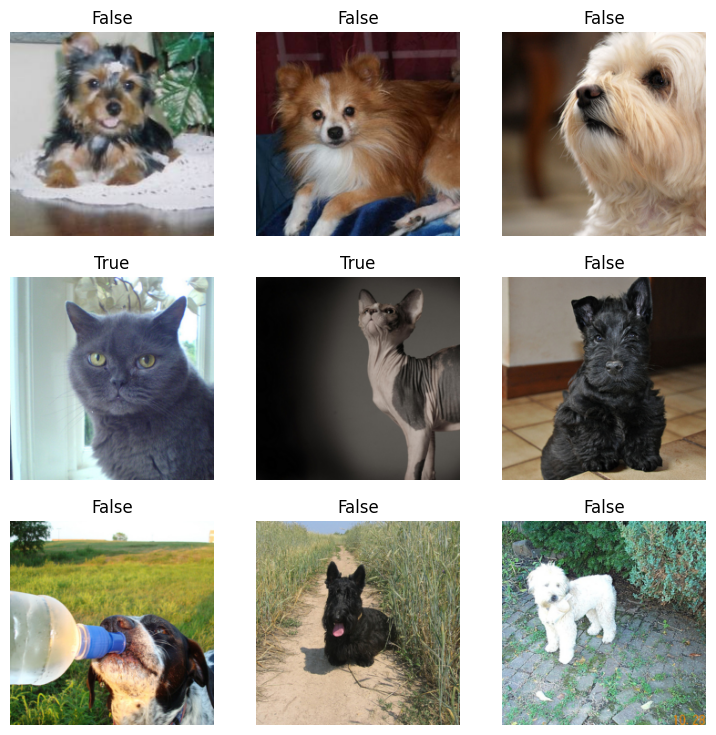

In [6]:
dls.show_batch()

## Training

In [8]:
learn = fv.vision_learner(dls, fv.resnet34, metrics=fv.error_rate)

In [9]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.156994,0.018946,0.006089,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.057612,0.020659,0.006766,00:31


## Model visualization (optional)
* Just skip this section if you don't have `idlmav`. Nothing depends on it.
* This is executed after fine-tuning here, because in one experiment, the `requires_grad` attribute of the `Conv2d` weight tensors were set to `False` before fine-tuning, resulting in the `Conv2d` layers showing zero parameters. This was not fixed by merely calling `learn.model.train(True)`.

In [10]:
from idlmav import MAV, MavOptions, RenderOptions, plotly_renderer
mav = MAV(learn.model, dls.one_batch(), MavOptions(device='cuda', try_fx_first=True))

In [11]:
with plotly_renderer('notebook_connected'): mav.show_figure(RenderOptions(add_overview=True, add_slider=True))

## Adding trainplotkit
* The `fastai` framework already provides the capability to seamlessly extend its training loop with callbacks
* Moreover, the information required by `trainplotkit` (i.e. batch inputs, targets, predictions and losses) are already available from the `Learner` object
* Just a simple adapter is therefore necessary to add `trainplotkit` to a `fastai` learner

In [24]:
class FastaiAdapter(fv.Callback):
    def __init__(self, pg:PlotGrid, **kwargs):
        super().__init__(**kwargs)
        self.pg = pg

    def before_fit(self):
        self.pg.before_fit()

    def after_batch(self):
        self.pg.after_batch(
            training=self.learn.training,
            inputs=self.learn.xb[0],
            targets=self.learn.yb[0],
            predictions=self.learn.pred,
            loss=self.learn.loss
        )

    def after_train(self):
        self.pg.after_epoch(training=True)

    def after_validate(self):
        self.pg.after_epoch(training=False)

    def after_fit(self):
        self.pg.after_fit()

In [14]:
sps = [TrainingCurveSP(colspan=1)]
pg = PlotGrid(num_grid_cols=1, subplots=sps, fig_height=300)
pg.show()

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Training loss',
              'type': 'scatter',
              'uid': '1c101901-5ffb-4812-b38d-f727bfa4cd74',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'mode': 'lines+markers',
              'name': 'Validation loss',
              'type': 'scatter',
              'uid': 'bb4f0dc4-f066-436d-8cf5-9734ea3d15e4',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'hoverinfo': 'skip',
              'marker': {'color': 'rgba(0,0,0,0.2)', 'line': {'color': 'black', 'width': 2}},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'uid': '4deff08f-8066-4489-9dbe-090f34921a0b',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'}],
    'layout': {'annotations': [{'font'

In [15]:
learn = fv.vision_learner(dls, fv.resnet34, metrics=fv.error_rate, cbs=[FastaiAdapter(pg)])
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.180654,0.022769,0.006766,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.058476,0.030899,0.011502,00:33
1,0.027132,0.004704,0.001353,00:36
2,0.013768,0.003116,0.000677,00:36


### Function to calculate loss for every sample
* Some plots (e.g. `ValidLossSP`) require a separate loss function that returns the loss for every sample in the batch. 
* Typical loss functions have this as an intermediate step, but perform an additional reduction (e.g. `mean` or `sum`) to return a single loss for the batch
* The `batch_loss_fn` required by subplots like `ValidLossSP` should not include this reduction. This is often possible by using the same PyTorch function and just adding an additional `reduction=None` keyword argument.

In [16]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [17]:
xb,yb = dls.one_batch()
pred = learn.model(xb)
xb.shape, yb.shape, pred.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]), torch.Size([64, 2]))

In [18]:
type(xb), type(yb), type(pred)

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorCategory,
 fastai.torch_core.TensorImage)

In [19]:
learn.loss_func(Tensor(pred), Tensor(yb))

TensorBase(0.0002, device='cuda:0', grad_fn=<AliasBackward0>)

In [20]:
nn.CrossEntropyLoss(reduction='none')(Tensor(pred), Tensor(yb))

tensor([-0.0000e+00, -0.0000e+00, 1.7308e-04, 4.1365e-05, 7.4265e-05, -0.0000e+00,
        2.3842e-07, 3.0179e-04, -0.0000e+00, 8.5830e-06, 7.7006e-05, 3.5763e-07,
        1.3709e-05, 3.8861e-05, 1.9024e-04, -0.0000e+00, -0.0000e+00, 5.9605e-07,
        1.5616e-05, -0.0000e+00, -0.0000e+00, 5.2452e-06, -0.0000e+00, -0.0000e+00,
        4.3272e-05, 2.0981e-05, 1.1921e-07, -0.0000e+00, 1.0610e-05, 7.1525e-06,
        -0.0000e+00, -0.0000e+00, 8.5830e-06, -0.0000e+00, 3.2186e-06, 4.8876e-06,
        1.0383e-04, -0.0000e+00, -0.0000e+00, 1.3113e-06, 3.2186e-06, 1.0106e-03,
        1.6689e-06, 9.4175e-06, 3.9339e-06, -0.0000e+00, 4.7851e-04, 5.3524e-05,
        -0.0000e+00, 3.7079e-04, 9.5367e-07, 9.0714e-05, 4.0531e-06, 1.5497e-06,
        6.7071e-03, 3.8147e-06, 1.1921e-07, 5.9605e-07, -0.0000e+00, 5.9960e-05,
        2.3842e-07, -0.0000e+00, 1.5497e-06, 8.4639e-04], device='cuda:0',
       grad_fn=<NllLossBackward0>)

In [82]:
reload_imports()

In [25]:
batch_loss_fn = nn.CrossEntropyLoss(reduction='none')
probs_fn = lambda preds: torch.softmax(preds, dim=1)
sps = [
    TrainingCurveSP(colspan=2), 
    ValidLossSP(batch_loss_fn, remember_past_epochs=True, colspan=2), 
    ImageSP(dls.train_ds, rowspan=2),
    MetricSP("Accuracy", MulticlassAccuracy(), colspan=2), 
    ClassProbsSP(probs_fn, remember_past_epochs=True, class_names=[f"{i}" for i in range(10)], colspan=2),
]
pg = PlotGrid(num_grid_cols=5, subplots=sps)
pg.show()

FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Training loss',
              'type': 'scatter',
              'uid': 'b158ca74-799b-44d8-9395-ffe231470919',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'mode': 'lines+markers',
              'name': 'Validation loss',
              'type': 'scatter',
              'uid': 'ea112878-f506-4c18-84da-dcf0fd3d02ec',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'hoverinfo': 'skip',
              'marker': {'color': 'rgba(0,0,0,0.2)', 'line': {'color': 'black', 'width': 2}},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'cb288159-5e84-4cac-b1ec-35d9486df125',
              'x': [],
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'mode': 'markers',
      

In [26]:
learn = fv.vision_learner(dls, fv.resnet34, metrics=fv.error_rate, cbs=[FastaiAdapter(pg)])
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.136463,0.022490,0.006766,02:20


epoch,train_loss,valid_loss,error_rate,time
0,0.087321,0.035738,0.012179,00:45
1,0.036630,0.008761,0.002030,00:42
2,0.022159,0.010020,0.002030,00:42


In [27]:
pg.show_static()

In [58]:
type(dls.train_ds[0][0])

fastai.vision.core.PILImage

In [70]:
Tensor(np.array(dls.train_ds[0][0])).shape

torch.Size([500, 499, 3])

In [74]:
type(dls.train_ds[0][1])

fastai.torch_core.TensorCategory

In [86]:
[Tensor(dls.train_ds[i][1]) for i in range(20)]

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(1)]